In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

# geometric distribution for trials prob(n) = p q^(n-1) where p is success probability
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
# photon transmission probability in fiber (i.e., 0.2dB/km)
Trans = lambda x: 10**(-0.2*x/10)
# Binary Shanon entropy
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

# no cutoff
For reference

In [11]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_sequential_no_cutoff(τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    T_tot = 2* np.sum( τs / (p_link*Trans(links)) )

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod(p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) ) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    return raw_rate, skr, F_e2e


## with cutoff 

In [13]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware


def T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    # implementing the recursion relation :
    ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
    p1 = p_link*Trans(links[0])
    T_tot = 2*τs[0]/p1
    for i_l in np.arange(1,len(links)):
        L = links[i_l]
        m_n = int(τ_cut/(2*τs[i_l]))
        p_n = p_link*Trans(L)
        Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
        Pm = 1- (1-p_n)**m_n
        T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    m_arr = np.floor(τ_cut/(2*τs))
    Pm_arr = 1- (1-p_link*Trans(links))**m_arr
    f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    # skr, F_e2e = 0, 0
    return raw_rate, skr, F_e2e


## rate vs. distance
uniform repeater chain

In [18]:
n = 8 # number of segments (i.e., no. of repeaters -1 )
τ_coh = 0.01
τ_cut = 0.1*τ_coh # cutoff
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Le2e_list = np.linspace(10,200,21) # e2e distance [km]
raw_rate_seq = np.zeros(len(Le2e_list))
skr_seq = np.zeros(len(Le2e_list))
Fe2e_seq = np.zeros(len(Le2e_list))

for i, Le2e in enumerate(Le2e_list):
    Ls = [Le2e/n]*n
    raw_rate_seq[i], skr_seq[i], Fe2e_seq[i] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)


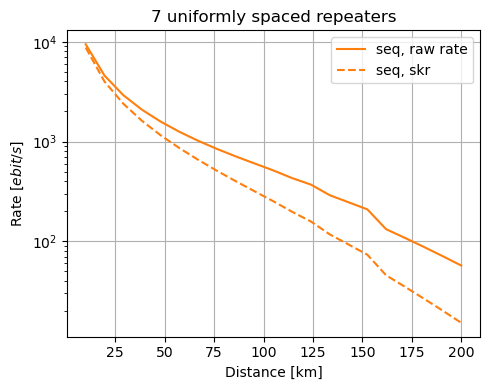

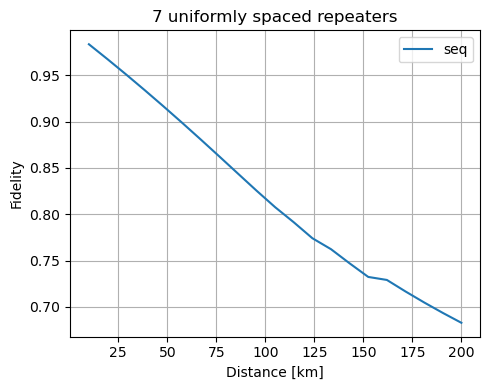

In [19]:
plt.figure(figsize=(5,4))
# plt.plot(Le2e_list,-np.log2(1-Trans(Le2e_list)),"k--", label="PLOB")
plt.plot(Le2e_list,raw_rate_seq,"-",color="C1", label="seq, raw rate")
plt.plot(Le2e_list,skr_seq,"--",color="C1", label="seq, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.title(f"{n-1} uniformly spaced repeaters")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


plt.figure(figsize=(5,4))
plt.plot(Le2e_list,Fe2e_seq,"-", label="seq")
plt.title(f"{n-1} uniformly spaced repeaters")
# plt.yscale("log")
plt.xlabel("Distance [km]")
# plt.ylabel(r"$T_{mem}/τ_{coh}$")
plt.ylabel("Fidelity")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
plt.show()


## Rate vs. cutoff time

In [48]:
Le2e = 250 # e2e distance [km]
n = 3 # number of segments (i.e., no. of repeaters -1 )
Ls = [Le2e/n]*n
τ_coh = 0.1 # coherence time [sec]
τ_cut_list = np.linspace(0.01,1.0,200)*τ_coh # cutoff [sec]

raw_rate_seq = np.zeros(len(τ_cut_list))
skr_seq = np.zeros(len(τ_cut_list))
Fe2e_seq = np.zeros(len(τ_cut_list))

for i_t, τ_cut in enumerate(τ_cut_list):
    raw_rate_seq[i_t], skr_seq[i_t], Fe2e_seq[i_t] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)


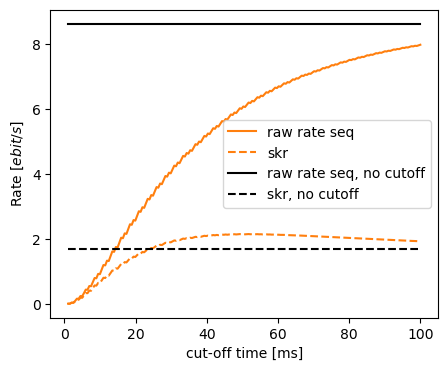

In [49]:
plt.figure(figsize=(5,4))

plt.plot(τ_cut_list*1e3,raw_rate_seq,"-",color="C1",label="raw rate seq")
plt.plot(τ_cut_list*1e3,skr_seq,"--",color="C1",label="skr")

# for reference:
raw_rate_seq_no_cut, skr_seq_no_cut, _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)
plt.plot(τ_cut_list*1e3,raw_rate_seq_no_cut+0*τ_cut_list , "k-",label="raw rate seq, no cutoff")
plt.plot(τ_cut_list*1e3,skr_seq_no_cut+0*τ_cut_list , "k--",label="skr, no cutoff")

plt.ylabel(r"Rate $[ebit/s]$")
plt.xlabel("cut-off time [ms]")
plt.legend()
plt.show()
